In [2]:
import torch
from torchvision import datasets, transforms
from sklearn.preprocessing import MultiLabelBinarizer
import os
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.optim as optim

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import numpy as np
from PIL import Image
import torch

#taken from ChatGPT
def load_data_from_subdirectory(path):
    """
    Load data from a subdirectory (train, val, or test). 
    Assumes the structure:
    path/
    ...class1/
    ......image1.jpg
    ......image2.jpg
    ...class2/
    ......image1.jpg
    ......image2.jpg
    """

    X = []
    Y = []

    labels = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

    for label in labels:
        label_path = os.path.join(path, label)
        
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            
            if not os.path.isfile(img_path):
                continue

            # Load and process the image
            img = Image.open(img_path)
            img = np.array(img)
            transform = transforms.ToTensor()
            
#             Process label
            one_hot = torch.zeros((1,10))
            one_hot[0,int(label)%10] = 1
            one_hot[0,int(label)//10] = 1
            
            if int(label)%10 != int(label)//10:
                X.append(transform(img))
                Y.append(one_hot)
    
    return torch.cat(X), torch.cat(Y)

def load_all_data(root_folder):
    train_path = os.path.join(root_folder, 'train')
    val_path = os.path.join(root_folder, 'val')
    test_path = os.path.join(root_folder, 'test')

    train_X, train_y = load_data_from_subdirectory(train_path)
    val_X, val_y = load_data_from_subdirectory(val_path)
    test_X, test_y = load_data_from_subdirectory(test_path)

    return train_X, train_y, val_X, val_y, test_X, test_y

# Usage
root_folder = './double_mnist'
train_X, train_y, val_X, val_y, test_X, test_y = load_all_data(root_folder)

print("Train data: X shape =", train_X.shape, "Y shape =", train_y.shape)
print("Validation data: X shape =", val_X.shape, "Y shape =", val_y.shape)
print("Test data: X shape =", test_X.shape, "Y shape =", test_y.shape)

Train data: X shape = torch.Size([58000, 64, 64]) Y shape = torch.Size([58000, 10])
Validation data: X shape = torch.Size([14000, 64, 64]) Y shape = torch.Size([14000, 10])
Test data: X shape = torch.Size([18000, 64, 64]) Y shape = torch.Size([18000, 10])


In [4]:
def get_label_from_one_hot(one_hot_vector):
    # Find the indices of the positions where there's a 1
    positions = np.where(one_hot_vector)[0]
    
    # Convert the indices to strings and join them
    label = ''.join(map(str, positions))
    return label

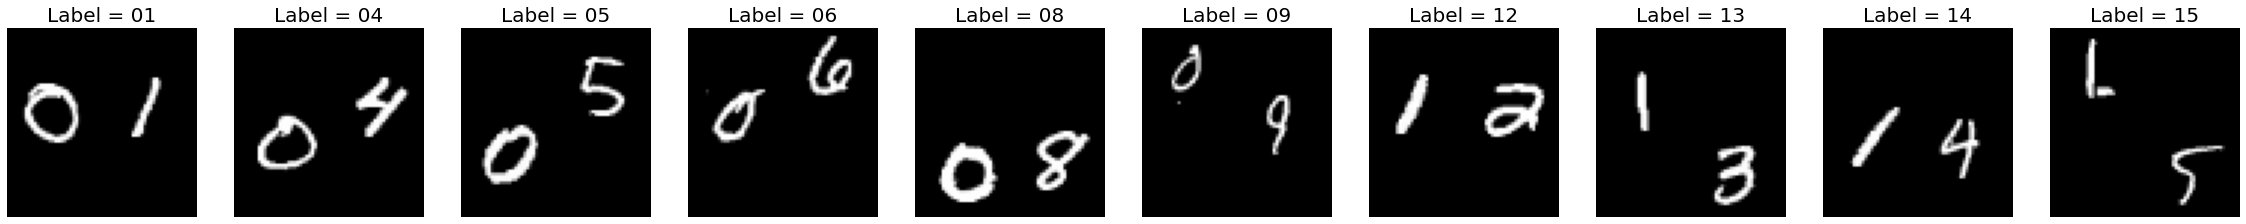

In [5]:
import matplotlib.pyplot as plt

def display_samples(samples, labels, num=10):
    max_l = num*1000
    plt.figure(figsize=(40,8*num))
    for index in range(0,max_l,1000):
        plt.subplot(1, num, index//1000+1)
        plt.imshow(samples[index], cmap='gray')
        plt.title(f'Label = {get_label_from_one_hot(labels[index])}',fontsize=20)
        plt.axis('off')
    plt.show()

display_samples(train_X.numpy(), train_y.numpy())

In [6]:
class DoubleMNISTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_dataset = DoubleMNISTDataset(train_X,train_y)
val_dataset = DoubleMNISTDataset(val_X,val_y)
test_dataset = DoubleMNISTDataset(test_X,test_y)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Multi MNIST MLP

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiMNISTMLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(MultiMNISTMLP, self).__init__()
        
        layers = []
        in_size = input_size
        
        for h_size in hidden_layers:
            layers.append(nn.Linear(in_size, h_size))
            layers.append(nn.ReLU())
            in_size = h_size
            
        layers.append(nn.Linear(in_size, output_size))
        layers.append(nn.Sigmoid())  # Sigmoid for multi-label classification
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.view(x.size(0), -1).float()  # Flatten the input
        # print(x.shape)
        # print(self.model)
        return self.model(x)

model = MultiMNISTMLP(4096, [512, 256], 10)

In [10]:
hidden_layer_configs = [[512,128], [256], [128, 128], [512, 256], [128, 256], [256, 128]]

best_val_accuracy = 0.0
best_model = None

for config in hidden_layer_configs:
    model = MultiMNISTMLP(4096, config, 10)
    optimizer = optim.Adam(model.parameters(),lr=0.2)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for multi-label classification
    
    # Train the model (assuming 5 epochs for demonstration)
    for epoch in range(10):
        print(f"epoch {epoch}")
        model.train()
        for images, labels in train_loader:  # labels here are already one-hot encoded
            outputs = model(images)
            # print(outputs,labels)
            loss = criterion(outputs, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Validate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            predicted = (outputs > 0.5).float()  # Apply threshold
            total += labels.size(0)
            correct+= (predicted == labels).sum().item()
            
    val_accuracy = correct / total
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model

    print(f"Config: {config} - Validation Accuracy: {val_accuracy*100:.2f}%")


epoch 0


/tmp/ipykernel_66641/4150324884.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Config: [512, 128] - Validation Accuracy: 800.00%
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Config: [256] - Validation Accuracy: 800.00%
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Config: [128, 128] - Validation Accuracy: 800.00%
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Config: [512, 256] - Validation Accuracy: 800.00%
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Config: [128, 256] - Validation Accuracy: 800.00%
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
Config: [256, 128] - Validation Accuracy: 800.00%


### From the above, for 10 epochs , all of the configurations are equivalent in terms of validation accuracy, hence we can say the best Hyperparameter : [512,256]

### CNN Model For Double MNIST

In [12]:
class DoubleMNISTModel(nn.Module):
    def __init__(self):
        super(DoubleMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*14*14, 128)  
        self.fc2_digit = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2_digit(x)
        x = nn.Sigmoid()(x)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DoubleMNISTModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader,epoch):
    model.train()
    total_loss = 0
    samples_trained = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.type('torch.FloatTensor')
        target = target.type('torch.FloatTensor')
        samples_trained+=target.shape[0]
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    total_loss /= samples_trained
    print(f"Epoch {epoch+1} total_train_loss = {total_loss}")
    

# Train for a few epochs (e.g., 5) for brevity
for epoch in range(50):
    train(model, train_loader,epoch)

/tmp/ipykernel_66641/4150324884.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1 total_train_loss = 0.006770751799681577
Epoch 2 total_train_loss = 0.002479771873560445
Epoch 3 total_train_loss = 0.001598061668188793
Epoch 4 total_train_loss = 0.0011892594269573174
Epoch 5 total_train_loss = 0.0009242775100845329
Epoch 6 total_train_loss = 0.000746736930643112
Epoch 7 total_train_loss = 0.0006199966115748574
Epoch 8 total_train_loss = 0.0005410682604304948


KeyboardInterrupt: 

In [14]:
# validation
# keep the threshold as 0.5

def multi_label_accuracy(output, target, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.
    
    :param output: Tensor of raw predictions, shape (batch_size, num_labels)
    :param target: True labels, shape (batch_size, num_labels)
    :param threshold: Decision threshold for determining label presence
    :return: Accuracy
    """
    with torch.no_grad():
        # Convert outputs to binary labels based on the threshold
        predicted_labels = (output > threshold).float()


        # Calculate number of correctly predicted labels for each sample
        correct_labels = (predicted_labels == target).float().sum(dim=1)

    
        # Calculate accuracy as ratio of correctly predicted labels to total labels
        overall_accuracy = (correct_labels == target.size(1)).float().sum()

        # Calculate overall accuracy
        # overall_accuracy = accuracy_per_sample.mean().item()

    return overall_accuracy

In [31]:
def multi_label_accuracy_hm(output, target, threshold=0.5):
    """
    Compute the accuracy for multi-label classification.
    
    :param output: Tensor of raw predictions, shape (batch_size, num_labels)
    :param target: True labels, shape (batch_size, num_labels)
    :param threshold: Decision threshold for determining label presence
    :return: Accuracy
    """
    with torch.no_grad():
        # Binarize the predictions
        y_pred_binarized = (output > threshold).float()
        
        # Calculate correct predictions
        correct = (y_pred_binarized == target).float().sum()
        
        # Total number of labels
        total = target.numel()  # Number of elements in y
        
        # print(correct,total)
        accuracy = correct
        return accuracy.item()

In [16]:
"""
Without hamming loss accuracy

"""
with torch.no_grad():
    train_acc =0 
    tot_samples = 0
    for (data, target) in val_loader:
        tot_samples+=len(data)
        data = data.type('torch.FloatTensor')
        target = target.type('torch.FloatTensor')
        
        data, target = data.to(device), target.to(device)
        output = model(data.unsqueeze(1))

        train_acc+=multi_label_accuracy(output,target)
    train_acc=train_acc/tot_samples
    print("The validation accuracy is :",train_acc.item())

/tmp/ipykernel_66641/4150324884.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


The validation accuracy is : 0.3703571557998657


#### Validation accuracy here (without hamming loss accuracy) : 37 %

In [32]:
"""
With hamming loss accuracy
"""

with torch.no_grad():
    train_acc =0 
    tot_samples = 0
    for (data, target) in val_loader:
        tot_samples+=len(data)*10
        data = data.type('torch.FloatTensor')
        target = target.type('torch.FloatTensor')
        
        data, target = data.to(device), target.to(device)
        output = model(data.unsqueeze(1))

        train_acc+=multi_label_accuracy_hm(output,target)
        # print(train_acc,len(data))
    # print(tot_samples,train_acc)
    train_acc=train_acc/tot_samples
    print("The validation accuracy is :",train_acc)

/tmp/ipykernel_66641/4150324884.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


The validation accuracy is : 0.9207642857142857


#### Validation accuracy here (with hamming loss accuracy) : 37 %

### Thus with Hamming loss we are able to achieve 92 % Accuracy

### Part 2

In [1]:
"""
Taken help from ChatGPT    
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Load the Permuted MNIST dataset
data = np.load("./permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]

# Split the training data into training and validation sets
permuted_x_train, permuted_x_val, y_train, y_val = train_test_split(permuted_x_train, y_train, test_size=0.2, random_state=42)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [34]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, output_size):
        super(MLPModel, self).__init__()
        layers = []
        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_size, neurons_per_layer))  # This should match input_size
        layers.append(nn.ReLU())
        for _ in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(neurons_per_layer, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Function to train the MLP model
def train_mlp(hidden_layers, neurons_per_layer, learning_rate, epochs):
    # Create PyTorch datasets and data loaders
    train_dataset = TensorDataset(torch.Tensor(permuted_x_train), torch.LongTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataset = TensorDataset(torch.Tensor(permuted_x_val), torch.LongTensor(y_val))
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_dataset = TensorDataset(torch.Tensor(permuted_x_test), torch.LongTensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Create the model
    model = MLPModel(28 * 28, hidden_layers, neurons_per_layer, 10)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total

        print(f'Epoch: {epoch}, Validation Accuracy: {val_accuracy:.2f}%, Train loss: {total_loss} ')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print("Test accuracy: ", test_accuracy)


num_epochs = 10
train_mlp(1, 128, 0.001, num_epochs)

Epoch: 0, Validation Accuracy: 0.92%, Train loss: 513.0276058465242 
Epoch: 1, Validation Accuracy: 0.94%, Train loss: 150.18634748458862 
Epoch: 2, Validation Accuracy: 0.95%, Train loss: 118.9108468387276 
Epoch: 3, Validation Accuracy: 0.95%, Train loss: 114.70433852123097 
Epoch: 4, Validation Accuracy: 0.95%, Train loss: 104.86624874878908 
Epoch: 5, Validation Accuracy: 0.95%, Train loss: 101.61066466837656 
Epoch: 6, Validation Accuracy: 0.94%, Train loss: 102.42999185674125 
Epoch: 7, Validation Accuracy: 0.95%, Train loss: 101.63809062441578 
Epoch: 8, Validation Accuracy: 0.95%, Train loss: 96.12828079680912 
Epoch: 9, Validation Accuracy: 0.95%, Train loss: 93.54784177261172 
Test accuracy:  0.9551


### With MLP, accuracy achievable in 10 epochs = 95.51 %

### CNN

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

from torchvision.transforms import ToTensor

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64*3*3, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.type('torch.FloatTensor')
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64*3*3)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CNN()

In [3]:
def evaluate(model, device, x_data, y_data):
    model.eval()
    correct = 0
    with torch.no_grad():
        x_data, y_data = x_data.to(device), y_data.to(device)
        output = model(x_data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y_data.view_as(pred)).sum().item()
    
    return 100. * correct / len(x_data)

In [4]:
print(permuted_x_train.shape)

(48000, 28, 28)


In [6]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.002)

def train(model, device, x_train, y_train,x_val,y_val,optimizer, epoch):
    model.train()
    x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
    x_val, y_val = torch.from_numpy(x_val), torch.from_numpy(y_val)
    
    optimizer.zero_grad()
    output = model(x_train)
    loss = F.cross_entropy(output, y_train)
    loss.backward()
    optimizer.step()
    
    train_accuracy = evaluate(model, device, x_train, y_train)
    val_accuracy = evaluate(model, device, x_val, y_val)
    print(f"Epoch: {epoch}, Loss: {loss.item()}, Train Acc: {train_accuracy}%, Val Acc: {val_accuracy}%")

# Your training loop:
for epoch in range(30):
    train(model, device,permuted_x_train,y_train,permuted_x_val,y_val,optimizer, epoch)

Epoch: 0, Loss: 2.101533889770508, Train Acc: 10.35625%, Val Acc: 10.133333333333333%
Epoch: 1, Loss: 3.053162097930908, Train Acc: 28.602083333333333%, Val Acc: 28.541666666666668%
Epoch: 2, Loss: 2.0897905826568604, Train Acc: 13.854166666666666%, Val Acc: 13.841666666666667%
Epoch: 3, Loss: 2.3977012634277344, Train Acc: 26.958333333333332%, Val Acc: 27.416666666666668%
Epoch: 4, Loss: 2.1467092037200928, Train Acc: 31.252083333333335%, Val Acc: 31.291666666666668%
Epoch: 5, Loss: 2.1006863117218018, Train Acc: 34.458333333333336%, Val Acc: 34.3%
Epoch: 6, Loss: 2.038681983947754, Train Acc: 29.589583333333334%, Val Acc: 29.391666666666666%
Epoch: 7, Loss: 2.035855770111084, Train Acc: 35.135416666666664%, Val Acc: 34.84166666666667%
Epoch: 8, Loss: 1.9937540292739868, Train Acc: 33.125%, Val Acc: 33.00833333333333%
Epoch: 9, Loss: 1.9647395610809326, Train Acc: 36.0625%, Val Acc: 36.18333333333333%
Epoch: 10, Loss: 1.9219778776168823, Train Acc: 41.95625%, Val Acc: 41.9083333333333

: 

: 

### Thus we are able to achieve 80% of the accuracy on the dataset

# Analysis CNN vs MLP

### 1. I think the CNN tends to converge a little slowly than MLP, but the increase of Accuracy in CNN is more than the increase of accuracy in MLP per epoch .


### 2. In terms of overfitting, the MLP will tend to overfit more quickly because of a large number of paramters due to the existence of only FC layers, while the convolutions in CNN will make the CNN spatially equivariant and can generalize more with weight sharing capabilities.

### THE END